# Logistic regression implementation  

In [1]:
#@title [Import libraries]
from IPython.display import display, Math, Latex
# Imported for proper rendering of latex in colab

import numpy as np

# Imports for generating plots
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
np.random.seed(1234)

# Implementation  

> In the first part of this exercise, we will implement individual components of binary logistic regression one by one.  

## Model  

In [3]:
# Let's implement linear combination in vectorized form  
def linear_combination(X: np.ndarray, w: np.ndarray) -> np.ndarray:
  return X @ w

In [4]:
# Let's implement sigmoid function in a vectorized form  
def sigmoid(z: np.ndarray) -> np.ndarray:
  return 1/(1+np.exp(-z))

In [5]:
# Let's implement the predict function
def predict(X:np.ndarray, w:np.ndarray, threshold:float) -> np.ndarray:
  return np.where(sigmoid(linear_combination(X, w)) > threshold, 1, 0)

Let's label a couple of samples through the code that we have written so far -

In [6]:
feature_matrix = np.array([[1, 20, 2], [1, 2, 2]])
weight_vector = np.array([-1, 0, 1])

print("Shape of feature matrix: ", feature_matrix.shape)
print("Shape of weight vector: ", weight_vector.shape)

class_labels = predict(feature_matrix, weight_vector, 0.5)

print("Shape of output: ", class_labels.shape)
print("The class label vector is: ", class_labels)

Shape of feature matrix:  (2, 3)
Shape of weight vector:  (3,)
Shape of output:  (2,)
The class label vector is:  [1 1]


## Loss function  

In [7]:
def loss(y, sigmoid_vector, weight_vector, l1_reg_rate, l2_reg_rate):
  return (-1 * (np.sum(y * np.log(sigmoid_vector) + (1-y) * np.log(1-sigmoid_vector)))) 
  + l2_reg_rate * np.dot(np.transpose(weight_vector), weight_vector) 
  + l1_reg_rate * np.sum(np.abs(weight_vector))

## Optimization  

GD, SGD and MBGD can be used.  
Here, we demonstrate GD.  

We need to modify gradient update rule that is suitable for logistic regression loss:  
* STEP 1: Calculate gradient of loss function and   
* STEP 2: Scale the gradient with learning rate and use it for updating the weight vector.  

### Gradient of loss function  

In [8]:
def calculate_gradient(X:np.ndarray, y:np.ndarray, w:np.ndarray, reg_rate:float) -> np.ndarray:
  return np.transpose(X) @ (sigmoid(linear_combination(X, w)) - y) + reg_rate * w

**Programming Exercises**  
1. Implement stochastic gradient descent for logistic regression classifier.  
2. Implement mini-batch gradient descent for logistic regression classifier. 

# Logistic regression class implementation  

We combine the different components above into a single python class with name LogisticRegression.  

It has the following class member variables:  
1. Weight vector  
2. Loss and weight vectors in each GD step  

In [9]:
class LogisticRegression(object):
  def set_weight_vector(self, w):
    self.w = w

  def linear_combination(self, X:np.ndarray) -> np.ndarray:
    return X @ self.w

  def sigmoid(self, z:np.ndarray) -> np.ndarray:
    return 1/(1 + np.exp(-z))

  def activation(self, X:np.ndarray) -> np.ndarray:
    return self.sigmoid(self.linear_combination(X))

  def predict(self, x:np.ndarray, threshold:float = 0.5):
    return (self.activation(x) > threshold).astype(int)

  def loss(self, X:np.ndarray, y:np.ndarray, reg_rate:float) -> float:
    predicted_prob = self.activation(X)
    return (-1 * (np.sum(y * np.log(predicted_prob) + (1-y) * np.log(1-predicted_prob))) +
    reg_rate * np.dot(np.transpose(self.w), self.w))

  def calculate_gradient(self, X:np.ndarray, y:np.ndarray, reg_rate:float) -> np.ndarray:
    return np.transpose(X) @ (self.activation(X) - y) + reg_rate * self.w

  def update_weights(self, grad:np.ndarray, lr:float) -> np.ndarray:
    return (self.w - lr*grad)

  def gd(self, X:np.ndarray, y:np.ndarray,
         num_epochs:int, lr:float, reg_rate:float) -> np.ndarray:
    self.w = np.zeros(X.shape[1])
    self.w_all = []
    self.err_all = []
    for i in np.arange(0, num_epochs):
      dJdw = self.calculate_gradient(X, y, reg_rate)
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X, y, reg_rate))
      self.w = self.update_weights(dJdw, lr)
    return self.w

# Demo #1: Logistic regression for linearly separable binary classification  

**Step 1**: As a first step, we will generate two linearly separable classes with 50 samples each. Each example is represented with two features.  

In [10]:
#@title [Toy dataset creation]  
def create_toy_data():
  x0 = np.random.normal(size=50).reshape(-1, 2) - 1
  x1 = np.random.normal(size=50).reshape(-1, 2) + 1
  return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(int)

In [11]:
feature_matrix, label_vector = create_toy_data()
print("Shape of feature matrix:", feature_matrix.shape)
print("Shape of label vector:", label_vector.shape)

Shape of feature matrix: (50, 2)
Shape of label vector: (50,)


In [12]:
assert feature_matrix.shape[0] == label_vector.shape[0]

**STEP 2**: Add a dummy feature corresponding to the bias. We make use of the polynomial transformation code that we have been using in previous colabs.  

In [13]:
#@title [Polynomial transformation] 
# Implementation adopted from (https://github.com/ctgk/PRML/blob/master/prml/preprocess/polynomial.py)

import numpy as np
import itertools
import functools

def get_combinations(x, degree):
  return itertools.combinations_with_replacement(x, degree)

def compute_new_feature(items):
  '''reduce(lambda x,y: x*y, [1,2,3,4,5]) calculates ((((1*2)*3)*4)*5)'''
  return functools.reduce(lambda x, y: x * y, items)

def polynomial_transform(x, degree, logging=False):
  # converts to feature matrix
  if x.ndim == 1:
    x = x[:, None]

  x_t = x.transpose()   # Transpose of feature matrix
  features = [np.ones(len(x))]    # Populates 1s as first feature for each example

  if logging:
    print(f"Input: {x}")

  for degree in range(1, degree+1):
    for items in get_combinations(x_t, degree):   # generate combinations.
      features.append(compute_new_feature(items)) # combine features into a new feature.
      if logging:
        print(f"{items}: {compute_new_feature(items)}")
  
  
  polynomial_feature_matrix = np.asarray(features).transpose()

  if logging:
    print(polynomial_feature_matrix)
  return polynomial_feature_matrix

In [14]:
feature_matrix_bias = polynomial_transform(feature_matrix, degree=1)

**STEP 3**: Separate data into training and test sets.  

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(feature_matrix_bias, label_vector)

In [16]:
assert x_train.shape[0] == y_train.shape[0]
assert x_test.shape[0] == y_test.shape[0]

**STEP 4**: Let's visualize the training data to get an idea of its distribution.  

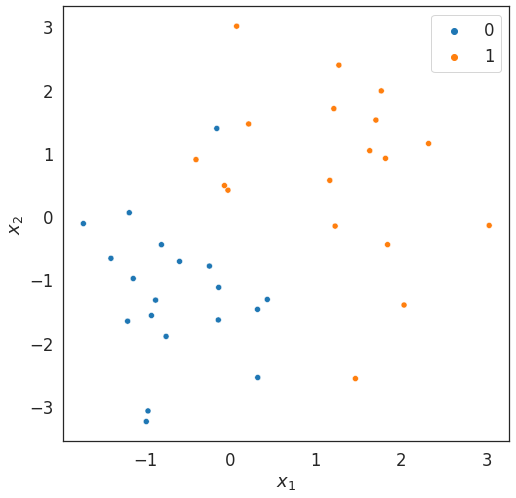

In [17]:
sns.set_style("white")
f = plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sns.scatterplot(data=x_train, x=x_train[:, -2], y=x_train[:, -1], hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Note that the two classes are linearly separable with most points within the boundary of their classes.  

**STEP 5**: We are all set to training a logistic regression on this problem.  
1. First instantiate a logistic regression object.  
2. Train the model with gradient descent procedure on the given training set.  

In [18]:
log_reg = LogisticRegression()
log_reg.gd(x_train, y_train, num_epochs=1000, reg_rate=0, lr=1e-2)

array([-0.14559758,  4.43289743,  1.94514132])

It is a good practice to examine the learning curve to make sure the model is able to learn with the current training set up. In cases, where the model is learning, the loss will reduce from one iteration to the next in gradient descent.  

In [19]:
#@title [Learning curves] 
def plot_learning_curves(err):
  plt.plot(np.arange(len(err)), err, "r-")
  plt.xlabel("iter #")
  plt.ylabel("$\mathbf{J(w)}$")

We use loss values stored during each step of GD for plotting the learning curve.  
Here is our learning curve - the iteration number is on x-axis an the loss is on y-axis.  

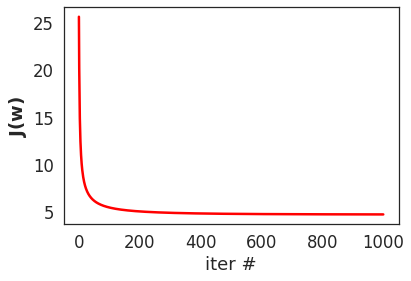

In [20]:
plot_learning_curves(log_reg.err_all)

Note that the loss drops smoothly as we proceed with GD.  
> This is an ideal learning curve for the model training task.  

Let's look at the final weight vector learnt by the model.  

In [21]:
print("Weight vector:", log_reg.w)

Weight vector: [-0.14559758  4.43289743  1.94514132]


Since the training data has only two features, we can visualize the decision boundary between two classes in 2D.  
For this, we will reuse the model visualization code from least square and perceptron classifiers.  


In [22]:
#@title [Model visualization] 
def visualize_model(x_train, y_train, regressor):
  print("INCOMPLETE CODE: Need to copy this visualization code from least square and perceptron classifiers in week 4!")

[Video link](https://youtu.be/bNCCd2qOfrU?t=625)

In [23]:
visualize_model(x_train, y_train, log_reg)

INCOMPLETE CODE: Need to copy this visualization code from least square and perceptron classifiers in week 4!


Our model learnt a reasonable decision boundary that is able to separate most point from two classes. 


Exercise: Rerun the model with different gradient descent settings and note down your observations about the decision boundary and the final weight vector. 

**STEP 6**: Model evaluation  
The next step is to use the model for making predictions on the new inputs. Let's predict labels on the test set - that was set aside for evaluating model performance.  

In [24]:
y_test_hat = log_reg.predict(x_test)

We compare these predictions with the actual labels and generate a classification report that includes several metrics like confusion matrix, precision, recall, F1 score etc.  

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



Note that our classifier has `precision` of 0.78 and `recall` of 1.0 on class label 1. The `f1-score` is 0.88.  

# Demo #2: Polynomial least square classification  